In [2]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fftpack, stats

In [104]:
from matplotlib import rcParams

config = {
    "font.family": 'serif', # 衬线字体
    "font.size": 10, # 相当于小四大小
    "font.serif": ['SimSun'], # 宋体
    "mathtext.fontset": 'stix', # matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
    'axes.unicode_minus': False # 处理负号，即-号
}
rcParams.update(config)

## 加载CWRU内圈故障数据

In [80]:
def data_acquision(FilePath):
    """
    fun: 从cwru mat文件读取加速度数据
    param file_path: mat文件绝对路径
    return accl_data: 加速度数据，array类型
    """
    data = scio.loadmat(file_path)  # 加载mat数据
    data_key_list = list(data.keys())  # mat文件为字典类型，获取字典所有的键并转换为list类型
    accl_key = data_key_list[3]  # 获取'X108_DE_time'
    accl_data = data[accl_key].flatten()  # 获取'X108_DE_time'所对应的值，即为振动加速度信号,并将二维数组展成一维数组
    return accl_data

[ 0.22269856  0.09323776 -0.14651649 ... -0.36125573  0.31138814
  0.17055689]


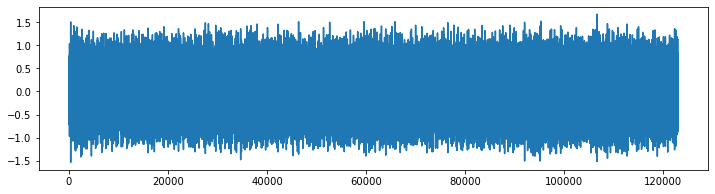

In [81]:
file_path = r'E:/研究生/pytorch/CSDN代码/fault_diagnosis_signal_processing/第4篇-包络谱/1730_12k_0.007-InnerRace.mat'
xt = data_acquision(file_path)
plt.figure(figsize=(12,3))
plt.plot(xt)
print(xt)

## 包络谱

### 希尔伯特黄变换

设$x(t)$为一个实时域信号，其Hilbert变换定义为：
$h(t)=\frac{1}{\pi} \int_{-\infty}^{+\infty} \frac{x(\tau)}{t-\tau} \mathrm{d} \tau=x(t) * \frac{1}{\pi t}$
则原始信号$x(t)$和它的Hilbert变换信号$h(t)$可以构建一个新的解析信号$z(t)$:
$z(t)=x(t)+j h(t)=a(t) e^{j \varphi t}$

In [82]:
# step1: 做希尔伯特变换
ht = fftpack.hilbert(xt)
print(ht)

[-0.02520403 -0.28707983 -0.00610516 ...  0.1100125   0.22821944
 -0.11203138]


对$z(t)$取模，得到其幅值$a(t):$

${a(t)=|z(t)|=\sqrt{x^{2}(t)+h^{2}(t)}}$

注：$a(t)$即为包络信号

### 获得包络信号

In [83]:
at = np.sqrt(ht**2+xt**2)   # at = sqrt(xt^2 + ht^2)

接下来对包络信号做fft即为包络信号

### 获得包络谱

In [84]:
sampling_rate = 12000
am = np.fft.fft(at)   # 对希尔伯特变换后的at做fft变换获得幅值
am = np.abs(am)       # 对幅值求绝对值（此时的绝对值很大）
am = am/len(am)*2
am = am[0: int(len(am)/2)]
freq = np.fft.fftfreq(len(at), d=1 / sampling_rate)  # 获取fft频率，此时包括正频率和负频率
freq = freq[0:int(len(freq)/2)]  # 获取正频率

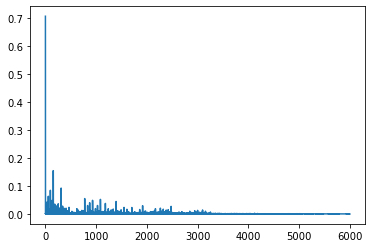

In [85]:
plt.plot(freq, am)

### 去直流分量

在0Hz的幅值比较高，使得其它频率幅值较低，不便观察。这种现象叫直流分量，去直流分量方法，y = y-mean(y)

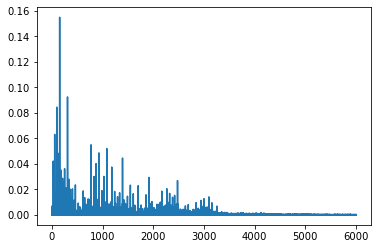

In [86]:
sampling_rate = 12000
at = at - np.mean(at)  # 去直流分量
am = np.fft.fft(at)    # 对希尔伯特变换后的at做fft变换获得幅值
am = np.abs(am)        # 对幅值求绝对值（此时的绝对值很大）
am = am/len(am)*2
am = am[0: int(len(am)/2)]
freq = np.fft.fftfreq(len(at), d=1 / sampling_rate)  # 获取fft频率，此时包括正频率和负频率
freq = freq[0:int(len(freq)/2)]  # 获取正频率
plt.plot(freq, am)

### 包络谱低频观察

(0.0, 500.0)

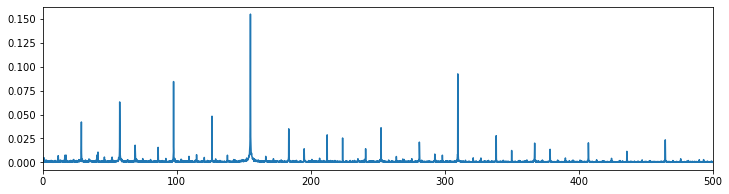

In [87]:
sampling_rate = 12000
at = at - np.mean(at)  # 去直流分量
am = np.fft.fft(at)    # 对希尔伯特变换后的at做fft变换获得幅值
am = np.abs(am)        # 对幅值求绝对值（此时的绝对值很大）
am = am/len(am)*2
am = am[0: int(len(am)/2)]
freq = np.fft.fftfreq(len(at), d=1 / sampling_rate)  # 获取fft频率，此时包括正频率和负频率
freq = freq[0:int(len(freq)/2)]  # 获取正频率
plt.figure(figsize=(12,3))
plt.plot(freq, am)
plt.xlim(0,500)

## 计算故障特征频率

内圈故障特征频率：$F_{\mathrm{BPFI}}=\frac{n f_{r}}{2}\left(1+\frac{d}{D} \cos \alpha\right)$

外圈故障特征频率：$F_{\mathrm{BPFO}}=\frac{n f_{r}}{2}\left(1-\frac{d}{D} \cos \alpha\right)$

滚动体故障特征频率：$F_{\mathrm{BSF}}=\frac{D f_{r}}{2 d}\left[1-\left(\frac{d}{D} \cos \alpha\right)^{2}\right]$

$n$: 滚动体个数，$f_{r}$: 轴转速 $d$: 滚珠(子)直径 $D$: 轴承节径

轴承型号为：6205-2RSL JME SKF 深沟球滚珠轴承

$d$=7.94mm, $D$=39.04mm, $\alpha$=0, $n$=9

### 定义一个轴承故障特征频率计算函数

In [109]:
def bearing_fault_freq_cal(n, d, D, alpha, fr=None):
    '''
    基本描述：
        计算滚动轴承的故障特征频率
    详细描述：
        输入4个参数 n, fr, d, D, alpha
    return C_bpfi, C_bpfo, C_bsf, C_ftf,  fr
           内圈    外圈    滚针   保持架  转速

    Parameters
    ----------
    n: integer
        The number of roller element
    fr: float(r/min)
        Rotational speed
    d: float(mm)
        roller element diameter
    D: float(mm)
        pitch diameter of bearing
    alpha: float(°)
        contact angle
    fr:：float(r/min)
        rotational speed
    Returns
    -------
    BPFI: float(Hz)
        Inner race-way fault frequency
    BPFO: float(Hz)
        Outer race-way fault frequency
    BSF: float(Hz)
        Ball fault frequency
    FTF: float(Hz)
        Cage frequency
    '''
    C_bpfi = n*(1/2)*(1+d/D*np.math.cos(alpha))
    C_bpfo = n*(1/2)*(1-(d/D)*np.math.cos(alpha))
    C_bsf = D*(1/(2*d))*(1-np.square(d/D*np.math.cos(alpha)))
    C_ftf = (1/2)*(1-(d/D)*np.math.cos(alpha))
    if fr!=None:
        return C_bpfi*fr/60, C_bpfo*fr/60, C_bsf*fr/60, C_ftf*fr/60, fr/60
    else:
        return C_bpfi, C_bpfo, C_bsf, C_ftf, fr

In [114]:
bpfi, bpfo, bsf, ftf, fr = bearing_fault_freq_cal(n=9, alpha=0, d=7.94, D=39.04, fr=1730)
print('内圈故障特征频率',bpfi)
print('外圈故障特征频率',bpfo)
print('滚动体故障特征频率',bsf)
print(ftf)
print(fr)

内圈故障特征频率 156.13870389344265
外圈故障特征频率 103.36129610655736
滚动体故障特征频率 67.9528924025478
11.48458845628415
28.833333333333332


## 理论故障特征频率与实际故障特征频率验证

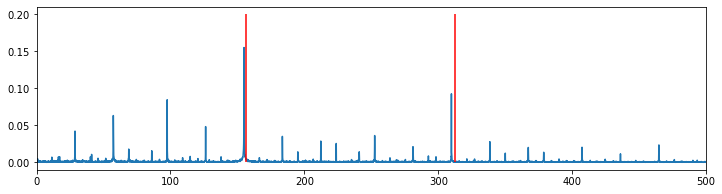

In [90]:
sampling_rate = 12000
at = at - np.mean(at)  # 去直流分量
am = np.fft.fft(at)    # 对希尔伯特变换后的at做fft变换获得幅值
am = np.abs(am)        # 对幅值求绝对值（此时的绝对值很大）
am = am/len(am)*2
am = am[0: int(len(am)/2)]
freq = np.fft.fftfreq(len(at), d=1 / sampling_rate)  # 获取fft频率，此时包括正频率和负频率
freq = freq[0:int(len(freq)/2)]  # 获取正频率
plt.figure(figsize=(12,3))
plt.plot(freq, am)
plt.xlim(0,500)
plt.vlines(x=156.13, ymin=0, ymax=0.2, colors='r')  # 一倍频
plt.vlines(x=156.13*2, ymin=0, ymax=0.2, colors='r')  # 二倍频

## 与fft进行对比分析

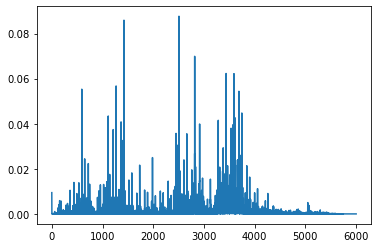

In [91]:
sampling_rate = 12000
am = np.fft.fft(xt)   # 对希尔伯特变换后的at做fft变换获得幅值
am = np.abs(am)       # 对幅值求绝对值（此时的绝对值很大）
am = am/len(am)*2
am = am[0: int(len(am)/2)]
freq = np.fft.fftfreq(len(xt), d=1 / sampling_rate)  # 获取fft频率，此时包括正频率和负频率
freq = freq[0:int(len(freq)/2)]  # 获取正频率
plt.plot(freq, am)

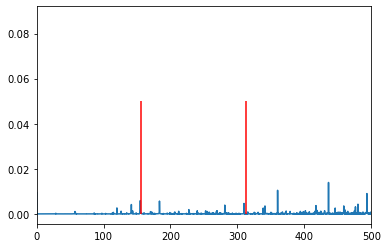

In [92]:
plt.plot(freq, am)
plt.xlim(0, 500)
plt.vlines(x=156.13, ymin=0, ymax=0.05, colors='r')  # 一倍频
plt.vlines(x=156.13*2, ymin=0, ymax=0.05, colors='r')  # 二倍频

## 封装为一个函数

In [107]:
def plt_envelope_spectrum(data, fs, xlim=None, vline= None):
    '''
    fun: 绘制包络谱图
    param data: 输入数据，1维array
    param fs: 采样频率
    param xlim: 图片横坐标xlim，default = None
    param vline: 图片垂直线，default = None
    '''
    #----去直流分量----#
    data = data - np.mean(data)
    #----做希尔伯特变换----#
    xt = data
    ht = fftpack.hilbert(xt)
    at = np.sqrt(xt**2+ht**2)   # 获得解析信号at = sqrt(xt^2 + ht^2)
    am = np.fft.fft(at)         # 对解析信号at做fft变换获得幅值
    am = np.abs(am)             # 对幅值求绝对值（此时的绝对值很大）
    am = am/len(am)*2
    am = am[0: int(len(am)/2)]  # 取正频率幅值
    freq = np.fft.fftfreq(len(at), d=1 / fs)  # 获取fft频率，此时包括正频率和负频率
    freq = freq[0:int(len(freq)/2)]  # 获取正频率
    plt.plot(freq, am)
    if vline:  # 是否绘制垂直线
        plt.vlines(x=vline, ymax=0.2, ymin=0, colors='r')  # 高度y 0-0.2，颜色红色
    if xlim: # 图片横坐标是否设置xlim
        plt.xlim(0, xlim)  
    plt.xlabel('freq(Hz)')    # 横坐标标签
    plt.ylabel('amp(m/s2)')   # 纵坐标标签

### 外圈故障数据测试

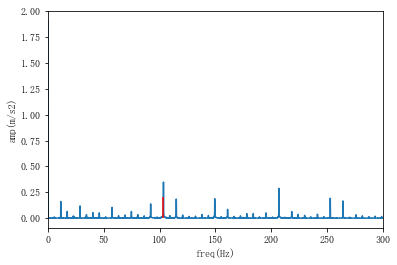

In [111]:
file_path = r'E:/研究生/pytorch/CSDN代码/fault_diagnosis_signal_processing/第4篇-包络谱/1730_12k_0.007-OuterRace3.mat'
data = data_acquision(file_path)
plt_envelope_spectrum(data = data, fs=12000, xlim=300, vline=bpfo)

可见实际外圈故障特征频率比较明显

### 滚动体故障数据测试分析

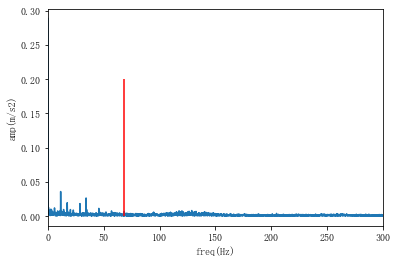

In [116]:
file_path = r'E:/研究生/pytorch/CSDN代码/fault_diagnosis_signal_processing/第4篇-包络谱/1730_12k_0.014-Ball.mat'
data = data_acquision(file_path)
plt_envelope_spectrum(data = data, fs=12000, xlim=300, vline=bsf)

可见实际滚动体故障特征频率不明显